In [48]:
import pandas as pd


df = pd.read_csv("../data/raw/upload_hak_list_08092024_1528.csv", sep=';')

In [49]:
import re
import numpy as np

## Первичная обработка

- Удалим prim_id
- Переименуем val1 -> source
- Уберем дубликаты (здесь они по всем фичам, кроме времени. Видимо, регистрировали по нескольку раз)

In [50]:
# Удалим prim_id
df = df.drop(columns=df.columns[0])

In [52]:
print(df.columns)
# Переименуем для ясности
df.rename(columns={'VAL1': 'SOURCE'}, inplace=True)

Index(['S_NAME', 'QUESTION', 'ANSWER', 'OPEN_TIME_', 'RESOLVE_TIME_',
       'CLOSE_TIME_', 'ATC_NEXT_BREACH_', 'TITLE', 'SUBCATEGORY', 'REG',
       'PRIORITY', 'AVARIYA', 'SOURCE'],
      dtype='object')


In [53]:
# Приводим даты к типу datetime 
for col in ['OPEN_TIME_', 'RESOLVE_TIME_', 'CLOSE_TIME_', 'ATC_NEXT_BREACH_']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

Заменим пустые значения Question на ''. Можно было бы скопировать Title, но это будет утечка данных для задачи генерации Title.
Для время обучения классификаторов объединим Question с Title в Question_full.

In [54]:
df['QUESTION'] = df['QUESTION'].fillna('')
df['QUESTION_FULL'] = df['TITLE'] + " " + df['QUESTION']

In [55]:
# Приведём текстовые поля к нижнему регистру
text_cols = ['QUESTION', 'ANSWER', 'TITLE']
for col in text_cols:
    df[col] = df[col].astype(str).str.lower().str.strip()

In [56]:
# Уберём лишние пробелы и спецсимволы
for col in text_cols:
    df[col] = df[col].apply(lambda x: re.sub(r'\s+', ' ', x))

## Обработка Subcategory

- Найдем опечатки и похожие названия
- Сольем редкие классы в "Прочее"
- Создадим маппинг для будущей модели

In [57]:
df['SUBCATEGORY'].value_counts()

SUBCATEGORY
Доступ к ИСОД                                      426664
Прочее                                             225925
Запрос на администрирование                        114223
Прочие вопросы                                      90547
Настройка ПО и оборудования                         15758
Авария                                              13887
Коррекция данных                                     8014
ОШС                                                  6312
Консультация                                         4445
Программное обеспечение.Региональные ПТК             3825
Запрос статуса                                       3638
Программное обеспечение                              1857
СПГУ.Несколько модулей                               1515
Запрос на доработку                                   934
Оборудование                                          209
СПГУ                                                  182
Запрос на консультацию в СОБТ                         123
Ин

Много мусорных классов. Подавляющее большинство в топ-4 класса. 

Объединим опечатки и похожие кассы, сольем мусорные классы в "Прочее".

In [58]:
from rapidfuzz import process, fuzz
import json

SIMILARITY_SCORE = 90

# 1. Ищем похожие классы по Левенштейну
unique_classes = df['SUBCATEGORY'].unique()
similar_map = {}

# Аггрегируем классы со схожестью > 90
for cls in unique_classes:
    matches = process.extract(
        cls, 
        unique_classes, 
        scorer=fuzz.ratio, 
        limit=None
    )
    similar_map[cls] = [m[0] for m in matches if m[0] != cls and m[1] >= 90]

In [59]:
print("\nПохожие классы (порог 90%):")
for k, v in similar_map.items():
    if v:
        print(f"- {k} -> {v}")


Похожие классы (порог 90%):
- Программное обеспечение.Региональные ПТК -> ['Программное обеспечение. Региональные ПТК', 'Програмное обеспечение. Региональные ПТК', 'Программное обеспечене. Региональные ПТК', 'Програмное обеспечение. Региональное ПТК']
- СПГУ.Несколько модулей -> ['СПГУ. Несколько модулей']
- СПГУ. Несколько модулей -> ['СПГУ.Несколько модулей']
- Програмное обеспечение. Региональное ПТК -> ['Програмное обеспечение. Региональные ПТК', 'Программное обеспечение. Региональные ПТК', 'Программное обеспечение.Региональные ПТК', 'Программное обеспечене. Региональные ПТК']
- Програмное обеспечение. Региональные ПТК -> ['Программное обеспечение. Региональные ПТК', 'Программное обеспечение.Региональные ПТК', 'Програмное обеспечение. Региональное ПТК', 'Программное обеспечене. Региональные ПТК']
- Программное обеспечение. Региональные ПТК -> ['Программное обеспечение.Региональные ПТК', 'Програмное обеспечение. Региональные ПТК', 'Программное обеспечене. Региональные ПТК', 'Програ

In [60]:
# Объединим похожие классы с учётом референсных (с правильным написанием)

PREFERRED_SUBCATS = ['Программное обеспечение. Региональные ПТК', 'СПГУ. Несколько модулей']

parent = {c: c for c in unique_classes}

def find(x):
    while parent[x] != x:
        parent[x] = parent[parent[x]]
        x = parent[x]
    return x

def union(a, b):
    ra, rb = find(a), find(b)
    if ra != rb:
        parent[rb] = ra

for cls, similars in similar_map.items():
    for s in similars:
        union(cls, s)

clusters = {}
for c in unique_classes:
    root = find(c)
    clusters.setdefault(root, []).append(c)

# Выбор референсов
counts = df['SUBCATEGORY'].value_counts()
similar_mapping = {}

for root, members in clusters.items():
    # Проверка на user-preferred
    preferred = None
    for pref in PREFERRED_SUBCATS:
        if pref in members:
            preferred = pref
            break
    
    if preferred:
        rep = preferred
    else:
        # Самый частый класс в кластере
        rep = max(members, key=lambda x: counts.get(x, 0))
    
    for m in members:
        similar_mapping[m] = rep

In [61]:
similar_mapping

{'Доступ к ИСОД': 'Доступ к ИСОД',
 'ОШС': 'ОШС',
 'Прочее': 'Прочее',
 'Прочие вопросы': 'Прочие вопросы',
 'Запрос на администрирование': 'Запрос на администрирование',
 'Запрос статуса': 'Запрос статуса',
 'Программное обеспечение.Региональные ПТК': 'Программное обеспечение. Региональные ПТК',
 'Програмное обеспечение. Региональное ПТК': 'Программное обеспечение. Региональные ПТК',
 'Програмное обеспечение. Региональные ПТК': 'Программное обеспечение. Региональные ПТК',
 'Программное обеспечение. Региональные ПТК': 'Программное обеспечение. Региональные ПТК',
 'Программное обеспечене. Региональные ПТК': 'Программное обеспечение. Региональные ПТК',
 'Авария': 'Авария',
 'Запрос на доработку': 'Запрос на доработку',
 'Консультация': 'Консультация',
 'СПГУ.Несколько модулей': 'СПГУ. Несколько модулей',
 'СПГУ. Несколько модулей': 'СПГУ. Несколько модулей',
 'Прочее.Региональные ПТК': 'Прочее.Региональные ПТК',
 'Оборудование.Региональные ПТК': 'Оборудование.Региональные ПТК',
 'Коррекц

In [62]:
df['SUBCATEGORY_CLEAN'] = df['SUBCATEGORY'].map(similar_mapping)

По какой-то причине после объединения отображений "Программное обеспечение..." и "СПГУ. Несколько модулей..." перезаписываются из rare_mapping, так что их в ручную меняем на значения из similar_mapping

In [83]:
MIN_SAMPLES = 200

# 2. Сливаем редкие классы
counts = df['SUBCATEGORY_CLEAN'].value_counts()
rare_classes = counts[counts < MIN_SAMPLES].index

rare_mapping = {}

for cls in unique_classes:
    if cls in rare_classes:
        rare_mapping[cls] = "Прочее"
    else:
        rare_mapping[cls] = similar_mapping[cls]

df['SUBCATEGORY_CLEAN'] = df['SUBCATEGORY_CLEAN'].map(rare_mapping)

In [ ]:
final_mapping = similar_mapping | rare_mapping

with open("../data/processed/subcategory_mapping.json", "w", encoding="utf-8") as f:
    json.dump(final_mapping, f, ensure_ascii=False, indent=2)
    
final_mapping

In [64]:
import matplotlib.pyplot as plt

<Axes: title={'center': 'После очистки'}, xlabel='SUBCATEGORY_CLEAN'>

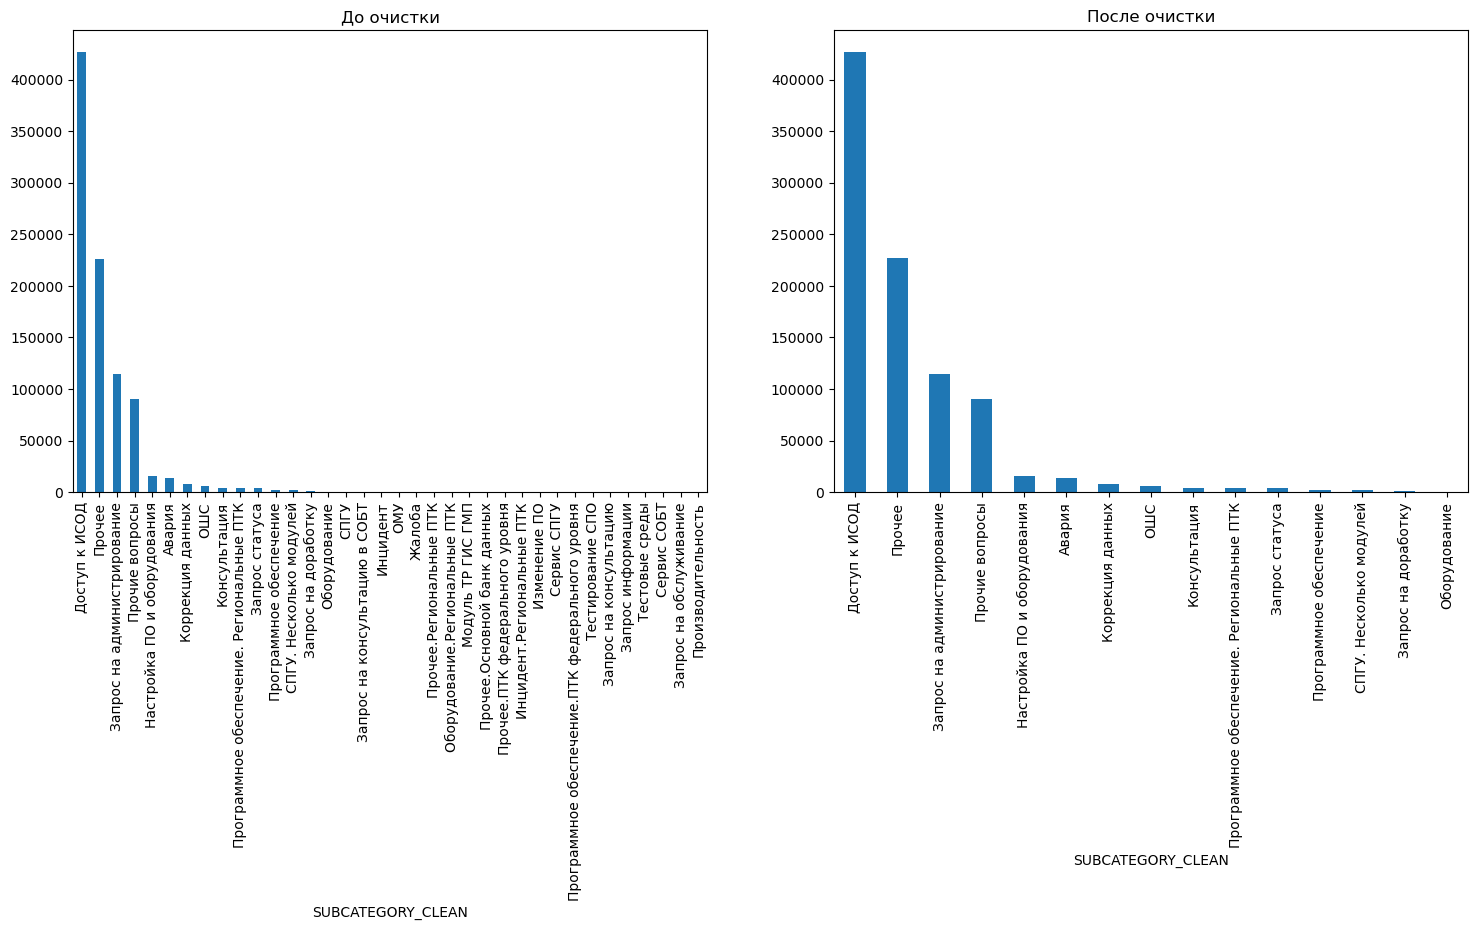

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

counts.plot(kind='bar', ax=axes[0], title="До очистки")
df['SUBCATEGORY_CLEAN'].value_counts().plot(kind='bar', ax=axes[1], title="После очистки")

In [66]:

df['SUBCATEGORY_CLEAN'].unique()

array(['Доступ к ИСОД', 'ОШС', 'Прочее', 'Прочие вопросы',
       'Запрос на администрирование', 'Запрос статуса',
       'Программное обеспечение. Региональные ПТК', 'Авария',
       'Запрос на доработку', 'Консультация', 'СПГУ. Несколько модулей',
       'Коррекция данных', 'Настройка ПО и оборудования', 'Оборудование',
       'Программное обеспечение'], dtype=object)

Удалим дубликаты по не временным фичам

In [68]:
not_time_cols = ['QUESTION', 'ANSWER', 'SUBCATEGORY', 'SOURCE', 'TITLE', 'REG', 'AVARIYA', 'S_NAME']

# Сортируем по времени, чтобы первая по времени была первой
df_sorted = df.sort_values(by='OPEN_TIME_')

# Маска дубликатов (оставляем первую по времени)
duplicates_mask = df_sorted.duplicated(subset=not_time_cols, keep='first')

# Индексы строк, которые будут удалены
duplicate_indices = df_sorted[duplicates_mask].index

# Удаляем дубликаты, оставляя первые по времени
df_no_duplicates = df_sorted[~duplicates_mask].reset_index(drop=True)

# Проверка
print("Количество удалённых дубликатов:", len(duplicate_indices))
print("Исходный размер:", df.shape)
print("Размер после удаления дубликатов:", df_no_duplicates.shape)

Количество удалённых дубликатов: 218607
Исходный размер: (918476, 15)
Размер после удаления дубликатов: (699869, 15)


In [70]:
np.save("../data/processed/duplicate_idx.npy", duplicate_indices)

In [75]:
df = df_no_duplicates

In [76]:
# Сохраняем результат
df.to_csv("../data/processed/cleaned_dataset.csv", index=False)

In [190]:
df['OPEN_TIME_'].dt.day_of_week

0         5
1         5
2         5
3         5
4         5
         ..
918471    6
918472    6
918473    6
918474    6
918475    6
Name: OPEN_TIME_, Length: 918476, dtype: int32